In [1]:
import time
import numpy as np

from gru_model import G_model
import torch
from torch import optim
from util import bce_loss, accuracy_function
from Paras import Para

from data_loader import train_loader, validation_loader, test_loader

Para.dataset_len = len(train_loader)
Para.log_step = len(train_loader) // 4
Para.epoch_num = 60

optimizer = torch.optim.RMSprop(G_model.parameters(), lr=1e-5)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)


def train(model, epoch, versatile=True):
    start_time = time.time()
    model = model.train()
    train_loss = 0.
    accuracy = 0.
    batch_num = len(train_loader)
    _index = 0

    for _index, data in enumerate(train_loader):
        spec_input, target = data['mel'], data['tag']

        if Para.cuda:
            spec_input = spec_input.cuda()
            target = target.cuda()

        optimizer.zero_grad()
        predicted = model(spec_input)

        loss_value = bce_loss(predicted, target)
        accuracy_value = accuracy_function(predicted, target)

        loss_value.backward()
        optimizer.step()

        train_loss += loss_value.data.item()
        accuracy += accuracy_value

        if versatile:
            if (_index + 1) % Para.log_step == 0:
                elapsed = time.time() - start_time
                print('Epoch{:3d} | {:3d}/{:3d} batches | {:5.2f}ms/ batch | BCE: {:5.4f} | Accuracy: {:5.2f}% |'
                      .format(epoch, _index + 1, batch_num,
                              elapsed * 1000 / (_index + 1),
                              train_loss / (_index + 1),
                              accuracy * 100 / (_index + 1)))

    train_loss /= (_index + 1)
    accuracy /= (_index + 1)

    print('-' * 99)
    print('End of training epoch {:3d} | time: {:5.2f}s | BCE: {:5.4f} | Accuracy: {:5.2f}% |'
          .format(epoch, (time.time() - start_time),
                  train_loss, accuracy * 100))

    return train_loss, accuracy


def validate_test(model, epoch, test=False):
    start_time = time.time()
    model = model.eval()
    v_loss = 0.
    accuracy = 0.
    data_loader_use = validation_loader if not test else test_loader
    _index = 0
    for _index, data in enumerate(data_loader_use):
        spec_input, target = data['mel'], data['tag']

        if Para.cuda:
            spec_input = spec_input.cuda()
            target = target.cuda()

        with torch.no_grad():

            predicted = model(spec_input)

            loss_value = bce_loss(predicted, target)
            accuracy_value = accuracy_function(predicted, target)

            v_loss += loss_value.data.item()
            accuracy += accuracy_value

    v_loss /= (_index + 1)
    accuracy /= (_index + 1)

    if not test:
        print('End of validation epoch {:3d} | time: {:5.2f}s | BCE: {:5.4f} | Accuracy: {:5.2f}% |'
              .format(epoch, (time.time() - start_time),
                v_loss, accuracy * 100))
    else:
        print('End of Test | time: {:5.2f}s | BCE: {:5.4f} | Accuracy: {:5.2f}% |'
              .format((time.time() - start_time),
                v_loss, accuracy * 100))
    print('-' * 99)

    return v_loss, accuracy

# Train the model here

In [2]:
t_loss, t_accu, v_loss, v_accu = [], [], [], []
decay_cnt = 0

for epoch in range(1, Para.epoch_num + 1):
    if Para.cuda:
        G_model.cuda()

    train_loss, train_accuracy = train(G_model, epoch)
    validation_loss, validation_accuracy = validate_test(G_model, epoch, test=False)

    t_loss.append(train_loss)
    t_accu.append(train_accuracy)

    v_loss.append(validation_loss)
    v_accu.append(validation_accuracy)

    # use accuracy to find the best model
    if np.max(t_accu) == t_accu[-1]:
        print('***Found Best Training Model***')
    if np.max(v_accu) == v_accu[-1]:
        with open(Para.MODEL_SAVE_PATH_2, 'wb') as f:
            torch.save(G_model.cpu().state_dict(), f)
            print('***Best Validation Model Found and Saved***')

    print('-' * 99)

    # Use BCE loss value for learning rate scheduling
    decay_cnt += 1

    if np.min(t_loss) not in t_loss[-3:] and decay_cnt > 2:
        scheduler.step()
        decay_cnt = 0
        print('***Learning rate decreased***')
        print('-' * 99)

Epoch  1 |  87/350 batches | 52.81ms/ batch | BCE: 0.3229 | Accuracy: 13.43% |
Epoch  1 | 174/350 batches | 56.02ms/ batch | BCE: 0.3204 | Accuracy: 17.35% |
Epoch  1 | 261/350 batches | 55.94ms/ batch | BCE: 0.3182 | Accuracy: 18.80% |
Epoch  1 | 348/350 batches | 56.69ms/ batch | BCE: 0.3159 | Accuracy: 20.08% |
---------------------------------------------------------------------------------------------------
End of training epoch   1 | time: 19.87s | BCE: 0.3159 | Accuracy: 20.09% |
End of validation epoch   1 | time:  1.02s | BCE: 0.3045 | Accuracy: 26.23% |
---------------------------------------------------------------------------------------------------
***Found Best Training Model***
***Best Validation Model Found and Saved***
---------------------------------------------------------------------------------------------------
Epoch  2 |  87/350 batches | 59.68ms/ batch | BCE: 0.3051 | Accuracy: 25.29% |
Epoch  2 | 174/350 batches | 59.46ms/ batch | BCE: 0.3031 | Accuracy: 25.65

Epoch 11 |  87/350 batches | 50.10ms/ batch | BCE: 0.2214 | Accuracy: 51.36% |
Epoch 11 | 174/350 batches | 54.52ms/ batch | BCE: 0.2195 | Accuracy: 51.72% |
Epoch 11 | 261/350 batches | 56.01ms/ batch | BCE: 0.2188 | Accuracy: 51.99% |
Epoch 11 | 348/350 batches | 56.36ms/ batch | BCE: 0.2185 | Accuracy: 52.42% |
---------------------------------------------------------------------------------------------------
End of training epoch  11 | time: 19.74s | BCE: 0.2185 | Accuracy: 52.48% |
End of validation epoch  11 | time:  0.95s | BCE: 0.2012 | Accuracy: 54.92% |
---------------------------------------------------------------------------------------------------
***Found Best Training Model***
***Best Validation Model Found and Saved***
---------------------------------------------------------------------------------------------------
Epoch 12 |  87/350 batches | 60.02ms/ batch | BCE: 0.2148 | Accuracy: 53.81% |
Epoch 12 | 174/350 batches | 59.61ms/ batch | BCE: 0.2128 | Accuracy: 53.81

Epoch 21 |  87/350 batches | 41.96ms/ batch | BCE: 0.1597 | Accuracy: 65.16% |
Epoch 21 | 174/350 batches | 41.81ms/ batch | BCE: 0.1606 | Accuracy: 66.13% |
Epoch 21 | 261/350 batches | 41.74ms/ batch | BCE: 0.1592 | Accuracy: 66.33% |
Epoch 21 | 348/350 batches | 41.73ms/ batch | BCE: 0.1600 | Accuracy: 66.29% |
---------------------------------------------------------------------------------------------------
End of training epoch  21 | time: 14.63s | BCE: 0.1601 | Accuracy: 66.29% |
End of validation epoch  21 | time:  0.70s | BCE: 0.1467 | Accuracy: 69.37% |
---------------------------------------------------------------------------------------------------
***Found Best Training Model***
***Best Validation Model Found and Saved***
---------------------------------------------------------------------------------------------------
Epoch 22 |  87/350 batches | 41.99ms/ batch | BCE: 0.1567 | Accuracy: 68.68% |
Epoch 22 | 174/350 batches | 41.77ms/ batch | BCE: 0.1556 | Accuracy: 68.46

Epoch 31 |  87/350 batches | 23.01ms/ batch | BCE: 0.1121 | Accuracy: 78.81% |
Epoch 31 | 174/350 batches | 27.10ms/ batch | BCE: 0.1126 | Accuracy: 78.12% |
Epoch 31 | 261/350 batches | 31.91ms/ batch | BCE: 0.1120 | Accuracy: 78.28% |
Epoch 31 | 348/350 batches | 34.35ms/ batch | BCE: 0.1123 | Accuracy: 78.25% |
---------------------------------------------------------------------------------------------------
End of training epoch  31 | time: 12.06s | BCE: 0.1123 | Accuracy: 78.21% |
End of validation epoch  31 | time:  0.70s | BCE: 0.1150 | Accuracy: 76.61% |
---------------------------------------------------------------------------------------------------
***Found Best Training Model***
***Best Validation Model Found and Saved***
---------------------------------------------------------------------------------------------------
Epoch 32 |  87/350 batches | 41.97ms/ batch | BCE: 0.1039 | Accuracy: 80.32% |
Epoch 32 | 174/350 batches | 41.80ms/ batch | BCE: 0.1072 | Accuracy: 79.67

Epoch 41 |  87/350 batches | 42.26ms/ batch | BCE: 0.0722 | Accuracy: 87.57% |
Epoch 41 | 174/350 batches | 41.95ms/ batch | BCE: 0.0751 | Accuracy: 86.24% |
Epoch 41 | 261/350 batches | 37.47ms/ batch | BCE: 0.0757 | Accuracy: 85.94% |
Epoch 41 | 348/350 batches | 33.38ms/ batch | BCE: 0.0770 | Accuracy: 85.47% |
---------------------------------------------------------------------------------------------------
End of training epoch  41 | time: 11.72s | BCE: 0.0770 | Accuracy: 85.48% |
End of validation epoch  41 | time:  0.70s | BCE: 0.0984 | Accuracy: 80.82% |
---------------------------------------------------------------------------------------------------
***Found Best Training Model***
***Best Validation Model Found and Saved***
---------------------------------------------------------------------------------------------------
Epoch 42 |  87/350 batches | 41.90ms/ batch | BCE: 0.0736 | Accuracy: 86.64% |
Epoch 42 | 174/350 batches | 41.78ms/ batch | BCE: 0.0748 | Accuracy: 86.46

Epoch 51 |  87/350 batches | 42.03ms/ batch | BCE: 0.0498 | Accuracy: 91.16% |
Epoch 51 | 174/350 batches | 41.81ms/ batch | BCE: 0.0512 | Accuracy: 90.70% |
Epoch 51 | 261/350 batches | 41.72ms/ batch | BCE: 0.0496 | Accuracy: 91.09% |
Epoch 51 | 348/350 batches | 41.08ms/ batch | BCE: 0.0502 | Accuracy: 91.13% |
---------------------------------------------------------------------------------------------------
End of training epoch  51 | time: 14.36s | BCE: 0.0501 | Accuracy: 91.12% |
End of validation epoch  51 | time:  0.38s | BCE: 0.0933 | Accuracy: 82.29% |
---------------------------------------------------------------------------------------------------
***Found Best Training Model***
---------------------------------------------------------------------------------------------------
Epoch 52 |  87/350 batches | 20.61ms/ batch | BCE: 0.0510 | Accuracy: 90.52% |
Epoch 52 | 174/350 batches | 31.17ms/ batch | BCE: 0.0498 | Accuracy: 90.91% |
Epoch 52 | 261/350 batches | 34.67ms/ ba

In [3]:
import matplotlib.pyplot as plt

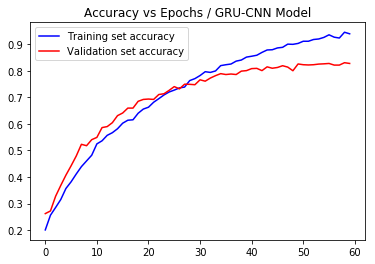

In [4]:
plt.figure()
plt.plot(t_accu, c='b', label='Training set accuracy')
plt.plot(v_accu, c='r', label='Validation set accuracy')
plt.title('Accuracy vs Epochs / GRU-CNN Model')
plt.legend()
plt.show()

In [5]:
import json
store_dict = dict()
store_dict['train_a'] = t_accu
store_dict['train_l'] = t_loss
store_dict['valid_a'] = v_accu
store_dict['valid_l'] = v_loss
with open('train_on_old_small_CRNN.json', 'w+') as f:
    json.dump(store_dict, f)